In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.preprocessing import PolynomialFeatures
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OrdinalEncoder
from datetime import datetime, time
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler

# Load data and data preprocessing

In [2]:
# Load data from Excel into a pandas DataFrame
data = pd.read_csv("data.csv")

# Convert DataFrame to NumPy array
numpy_array = data.to_numpy()

## Extract current data (From Year 2023)
Target variable is the ticket price. The data are from 2010 and 2023, 2010 is too old, so only use data from year 2023, which starts in line 1026

In [3]:
Ytarget=numpy_array[1026:,-1] 

In [4]:
Xdata=numpy_array[1026:,:-1]
Xdata[0]

array(['10/13/23', 'Friday', '1:30pm', 'B737', 82.92, 57, 'Thursday', 194,
       194, 193], dtype=object)

## Remove outliers

In [5]:
#remove outliers

# Compute the mean and standard deviation
mean = np.mean(Ytarget)
std_dev = np.std(Ytarget)

# Find the indices of data points that are within 3 standard deviations from the mean
indices = np.where(np.abs(Ytarget - mean) < 5 * std_dev)[0]
print(indices)

# Remove the outliers from the dataset
Ytarget = Ytarget[indices]
Xdata = Xdata[indices,:]

[   0    1    2 ... 4386 4387 4388]


## Encode the data

In [6]:
# Define weekdays in the desired order
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
 
# Create an instance of OrdinalEncoder and fit it to weekdays
encoder = OrdinalEncoder(categories=[weekdays])
encoder.fit(np.array(weekdays).reshape(-1, 1))

# Transform data
X_weekday1=Xdata[:,1]
X_weekday2=Xdata[:,6]
weekdays_encoded1 = encoder.transform(X_weekday1.reshape(-1, 1))
weekdays_encoded2 = encoder.transform(X_weekday2.reshape(-1, 1))

In [7]:
# convert time to 24 hour format, in double as type, i.e., 10:30am as 10.5

def convert_to_24_hour_double(time_str):
    # Parse the time string in AM/PM format
    time_obj = datetime.strptime(time_str, '%I:%M%p').time()
    
    # Convert to 24-hour format with period as separator
    hours = time_obj.hour
    minutes = time_obj.minute
    time_24_hour_double = hours + minutes / 60.0
    
    return time_24_hour_double

timeconvert=np.array([convert_to_24_hour_double(i) for i in Xdata[:,2]])
timeconvert

array([13.5       , 13.5       , 13.5       , ...,  8.83333333,
        8.83333333,  8.83333333])

In [8]:
#extract days in month
def extract_day(date_str):
    # Parse the date string
    date_obj = datetime.strptime(date_str, '%m/%d/%y')
    
    # Extract the day
    day = date_obj.day
    
    return day

In [9]:
dayconvert=np.array([extract_day(i) for i in Xdata[:,0]])
dayconvert

array([13, 13, 13, ..., 21, 21, 21])

In [10]:
#encode plane type

# Initialize the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the data
one_hot_encoded = encoder.fit_transform(Xdata[:,3].reshape(-1, 1))

# Convert the sparse matrix to array and print
typeconvert=one_hot_encoded.toarray()
print(typeconvert)

[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


## Combine encoded data together

In [12]:
#combine encoded data together

Xdatatotal=np.hstack((dayconvert.reshape(-1, 1),weekdays_encoded1.reshape(-1, 1),timeconvert.reshape(-1, 1),typeconvert,Xdata[:,4:6],weekdays_encoded2.reshape(-1, 1),Xdata[:,7:]))
Xdatatotal[0:5]

array([[13, 4.0, 13.5, 0.0, 0.0, 1.0, 0.0, 0.0, 82.92, 57, 3.0, 194, 194,
        193],
       [13, 4.0, 13.5, 0.0, 0.0, 1.0, 0.0, 0.0, 84.24, 56, 4.0, 194, 193,
        185],
       [13, 4.0, 13.5, 0.0, 0.0, 1.0, 0.0, 0.0, 84.99, 55, 5.0, 193, 185,
        186],
       [13, 4.0, 13.5, 0.0, 0.0, 1.0, 0.0, 0.0, 85.56, 54, 6.0, 185, 186,
        194],
       [13, 4.0, 13.5, 0.0, 0.0, 1.0, 0.0, 0.0, 84.91, 53, 0.0, 186, 194,
        192]], dtype=object)

## Creat train/val/test set and normalize data (standard scaler of sklearn)

In [75]:
X_train1, X_test, y_train1, y_test = train_test_split(Xdatatotal, Ytarget, test_size=0.2, random_state=42) #get test set

In [76]:
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42) #get val/train set

In [77]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler
scaler.fit(X_train)

# Transform data using the fitted scaler
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Linear regression

In [56]:
# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_val_scaled)

# Calculate mean squared error 
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error for val set:", mse)

# training error
y_predt = model.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_predt)
print("Mean Squared Error for train set:", mse)

Mean Squared Error for val set: 222.04543181945164
Mean Squared Error for train set: 222.13534428322353


## Linear regression model with regularazation

Alpha:  1e-05
Mean Squared Error for val set: 222.04543333293654
Mean Squared Error for train set: 222.135344283224
Alpha:  0.001
Mean Squared Error for val set: 222.04558317047983
Mean Squared Error for train set: 222.13534428770726
Alpha:  0.01
Mean Squared Error for val set: 222.04694555560582
Mean Squared Error for train set: 222.13534473148886
Alpha:  0.1
Mean Squared Error for val set: 222.06059168602505
Mean Squared Error for train set: 222.13538900115518
Alpha:  1
Mean Squared Error for val set: 222.19920139656705
Mean Squared Error for train set: 222.13970986966228
Alpha:  10
Mean Squared Error for val set: 223.73711040244103
Mean Squared Error for train set: 222.48538865842858
Alpha:  100
Mean Squared Error for val set: 238.78323041096456
Mean Squared Error for train set: 231.67557392659214


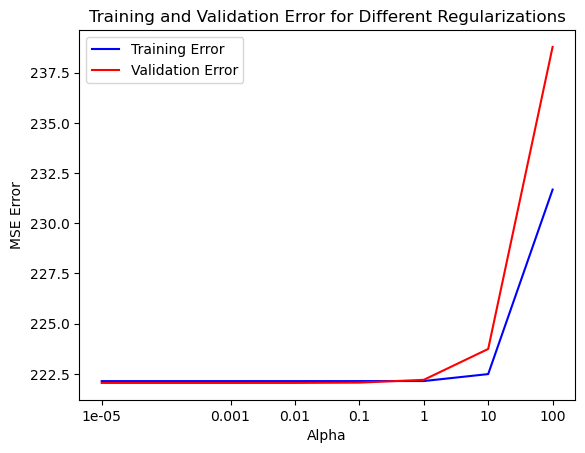

In [108]:
# Create a linear regression model with regularazation
alphalist=[1e-5,1e-3,1e-2,0.1,1,10,100]
weights=[]
vallist=[]
trainlist=[]

for a in alphalist:
    print("Alpha: ", a)
    
    model = Ridge(alpha=a)

    # Train the model on the training data
    model.fit(X_train_scaled, y_train)
    #print(model.coef_)
    weights.append(model.coef_)

    # Make predictions on the testing data
    y_pred = model.predict(X_val_scaled)

    # Calculate mean squared error 
    mse = mean_squared_error(y_val, y_pred)
    print("Mean Squared Error for val set:", mse)
    vallist.append(mse)
    
    # training error
    y_predt = model.predict(X_train_scaled)
    mse = mean_squared_error(y_train, y_predt)
    print("Mean Squared Error for train set:", mse)
    trainlist.append(mse)

x=[-5,-3,-2,-1,0,1,2]
# Plotting training and val errors
plt.plot(x, trainlist, label='Training Error', color='blue')
plt.plot(x, vallist, label='Validation Error', color='red')

# Adding labels and title
plt.xticks(x,[1e-5,1e-3,1e-2,0.1,1,10,100])
plt.xlabel('Alpha')
plt.ylabel('MSE Error')
plt.title('Training and Validation Error for Different Regularizations')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

In [109]:
print(weights)

[array([ 0.62682578,  0.76147645,  0.35617241, -0.08645355,  0.1875158 ,
        0.14313872, -0.07706678, -0.90501771, -0.43379968, -0.75861686,
        0.92776285, 13.19224543,  2.94440486, 46.11993956]), array([ 0.62682514,  0.76148054,  0.35617327, -0.0864545 ,  0.18751655,
        0.1431374 , -0.07706643, -0.90501721, -0.43379983, -0.75861485,
        0.92776139, 13.19222239,  2.94469835, 46.11965735]), array([ 0.62681926,  0.76151778,  0.35618105, -0.08646242,  0.18752561,
        0.1431279 , -0.07706178, -0.90501204, -0.4338012 , -0.75859659,
        0.92774806, 13.19201307,  2.94736605, 46.11709208]), array([ 0.62676055,  0.7618901 ,  0.35625876, -0.0865416 ,  0.18761613,
        0.14303295, -0.07701535, -0.90495994, -0.43381474, -0.75841396,
        0.92761484, 13.18993455,  2.97399707, 46.09147092]), array([ 0.62617544,  0.7656023 ,  0.35702531, -0.08733068,  0.18851506,
        0.14208486, -0.07656035, -0.90440647, -0.43393958, -0.75659103,
        0.92628773, 13.17057834,  3

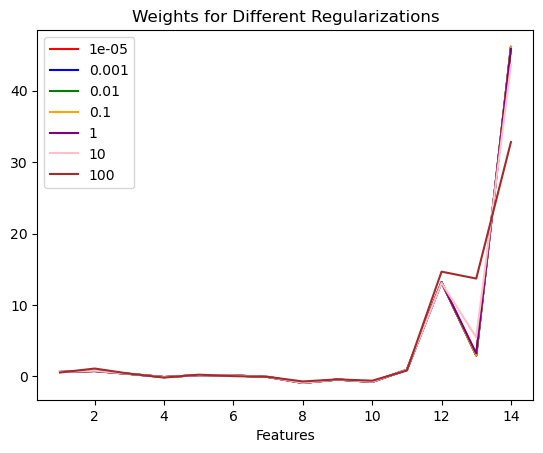

In [110]:
x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14]
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown']

# Plotting training and val errors
for i in range(7):
    plt.plot(x, weights[i], label=alphalist[i], color=colors[i])


# Adding labels and title
plt.xlabel('Features')
#plt.ylabel('MSE Error')
plt.title('Weights for Different Regularizations')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

## Linear regression model with feature transformation

Kernel:  linear
Mean Squared Error for val set: 222.06059168602505
Mean Squared Error for train set: 222.13538900115518
Kernel:  polynomial
Mean Squared Error for val set: 234.52832226999726
Mean Squared Error for train set: 186.16316886050015
Kernel:  rbf
Mean Squared Error for val set: 276.64353146664
Mean Squared Error for train set: 140.15536258396327


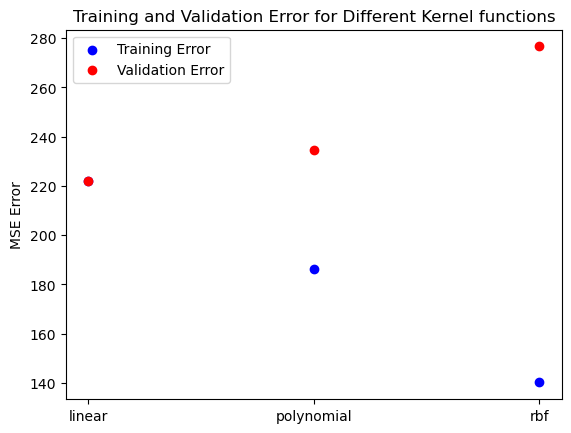

In [39]:
# Create a KernelRidge model with a specified kernel function

kernelfun=['linear','polynomial','rbf']
vallist=[]
trainlist=[]

for k in kernelfun:
    print("Kernel: ", k)
    if k=='linear':
        model = Ridge(alpha=0.1)
    else:
        model = KernelRidge(alpha=0.1, kernel= k,degree=2)

    # Train the model on the training data
    model.fit(X_train_scaled, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_val_scaled)

    # Calculate mean squared error 
    mse = mean_squared_error(y_val, y_pred)
    print("Mean Squared Error for val set:", mse)
    vallist.append(mse)

    # training error
    y_predt = model.predict(X_train_scaled)
    mse = mean_squared_error(y_train, y_predt)
    print("Mean Squared Error for train set:", mse)
    trainlist.append(mse)


x = [1,2,3]

# Define labels for x-axis
labels = ['linear','polynomial','rbf']

# Plotting the scatter plot
plt.scatter(x, trainlist, label='Training Error', color='blue')
plt.scatter(x, vallist, label='Validation Error', color='red')

# Adding labels and title
plt.ylabel('MSE Error')
plt.title('Training and Validation Error for Different Kernel functions')

# Change x-axis to display labels
plt.xticks(x, labels)

# Adding legend
plt.legend()

# Displaying the scatter plot
plt.show()

## Linear regression model with different parameters

degree:  1
Mean Squared Error for val set: 222.2706319381373
Mean Squared Error for train set: 222.14383025039905
degree:  2
Mean Squared Error for val set: 234.52832226999726
Mean Squared Error for train set: 186.16316886050015
degree:  3
Mean Squared Error for val set: 368.0490406307969
Mean Squared Error for train set: 150.02944424701184
degree:  4
Mean Squared Error for val set: 923.4162169528594
Mean Squared Error for train set: 117.27661640705475
degree:  5
Mean Squared Error for val set: 1202.746571876137
Mean Squared Error for train set: 88.77254606597654


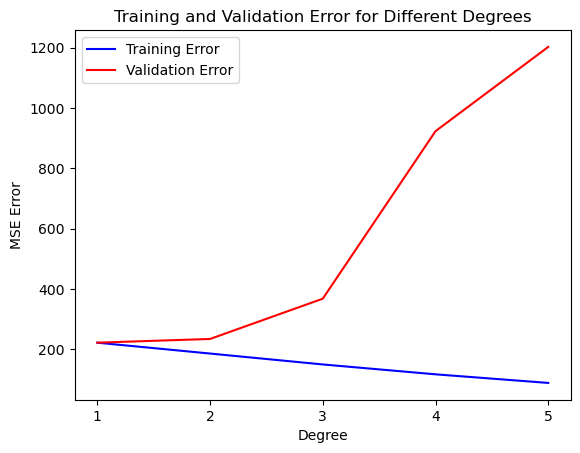

In [40]:
# Create a KernelRidge model with different parameters (degree of poly kernel)
degree=[1,2,3,4,5]
vallist=[]
trainlist=[]

for d in degree:
    print("degree: ", d)
    model = KernelRidge(alpha=0.1, kernel= 'poly',degree=d)

    # Train the model on the training data
    model.fit(X_train_scaled, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_val_scaled)

    # Calculate mean squared error 
    mse = mean_squared_error(y_val, y_pred)
    print("Mean Squared Error for val set:", mse)
    vallist.append(mse)

    # training error
    y_predt = model.predict(X_train_scaled)
    mse = mean_squared_error(y_train, y_predt)
    print("Mean Squared Error for train set:", mse)
    trainlist.append(mse)


# Plotting training and val errors
plt.plot(degree, trainlist, label='Training Error', color='blue')
plt.plot(degree, vallist, label='Validation Error', color='red')

# Adding labels and title
plt.xticks(degree,[1,2,3,4,5])
plt.xlabel('Degree')
plt.ylabel('MSE Error')
plt.title('Training and Validation Error for Different Degrees')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

## Optimal parameters and Test error

In [78]:
#from the results, simple linear regression is best, compute test error

# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test_scaled)

# Calculate mean squared error 
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error for test set:", mse)

Mean Squared Error for test set: 248.28667488803654


In [79]:
#weights

model.coef_

array([ 0.62682579,  0.7614764 ,  0.3561724 , -0.08645362,  0.18751555,
        0.14313845, -0.07706695, -0.90501779, -0.43379968, -0.75861688,
        0.92776287, 13.19224566,  2.94440189, 46.11994241])

In [81]:
model.intercept_

123.1913756236636

# Support Vector Regression

## SVR with different feature transformations

Kernel:  linear
Mean Squared Error for val set: 224.35240790434614
Mean Squared Error for train set: 226.22556939941953
Kernel:  poly
Mean Squared Error for val set: 529.4194130591412
Mean Squared Error for train set: 398.3892722182254
Kernel:  rbf
Mean Squared Error for val set: 335.683389650606
Mean Squared Error for train set: 263.9913640010442


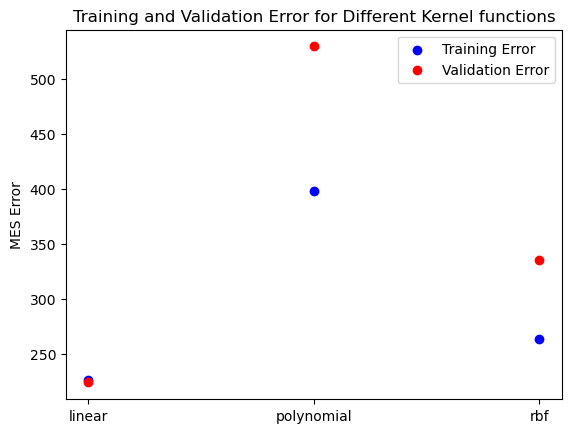

In [20]:
# Create a SVR model

kernelfun=['linear','poly','rbf']
vallist=[]
trainlist=[]

for k in kernelfun:
    print("Kernel: ", k)
    model = SVR(kernel=k,C=10,epsilon=10)

    # Train the model on the training data
    model.fit(X_train_scaled, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_val_scaled)

    # Calculate mean squared error 
    mse = mean_squared_error(y_val, y_pred)
    print("Mean Squared Error for val set:", mse)
    vallist.append(mse)

    # training error
    y_predt = model.predict(X_train_scaled)
    mse = mean_squared_error(y_train, y_predt)
    print("Mean Squared Error for train set:", mse)
    trainlist.append(mse)

x = [1,2,3]

# Define labels for x-axis
labels = ['linear','polynomial','rbf']

# Plotting the scatter plot
plt.scatter(x, trainlist, label='Training Error', color='blue')
plt.scatter(x, vallist, label='Validation Error', color='red')

# Adding labels and title
plt.ylabel('MES Error')
plt.title('Training and Validation Error for Different Kernel functions')

# Change x-axis to display labels
plt.xticks(x, labels)

# Adding legend
plt.legend()

# Displaying the scatter plot
plt.show()

## SVR with different regularizations

C:  0.001
Mean Squared Error for val set: 3546.2627492209226
Mean Squared Error for train set: 3325.1183770438874
C:  0.01
Mean Squared Error for val set: 635.6888488281315
Mean Squared Error for train set: 559.6278532993894
C:  0.1
Mean Squared Error for val set: 261.4777529768679
Mean Squared Error for train set: 250.8586652764327
C:  1
Mean Squared Error for val set: 228.75017376166295
Mean Squared Error for train set: 227.39114101189426
C:  10
Mean Squared Error for val set: 224.35240790434614
Mean Squared Error for train set: 226.22556939941953
C:  100
Mean Squared Error for val set: 223.9410541323429
Mean Squared Error for train set: 226.2057681915545
C:  1000
Mean Squared Error for val set: 223.89394371428156
Mean Squared Error for train set: 226.27841899654865


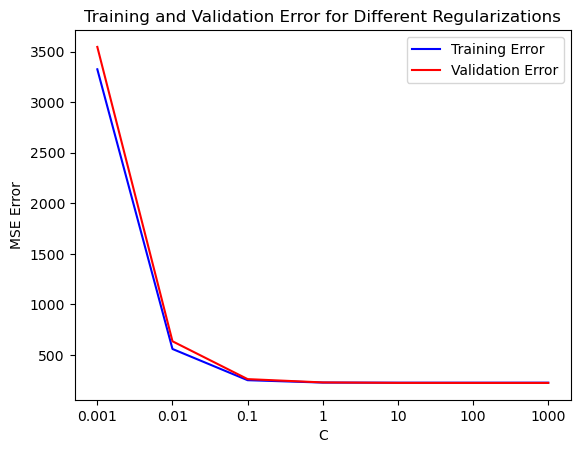

In [111]:
# Create a SVR model with regularization

Clist=[1e-3,1e-2,0.1,1,10,100,1000]
vallist=[]
trainlist=[]
weights=[]

for a in Clist:
    print("C: ", a)
    model = SVR(kernel='linear',C=a,epsilon=10)

    # Train the model on the training data
    model.fit(X_train_scaled, y_train)
    weights.append(model.coef_)

    # Make predictions on the testing data
    y_pred = model.predict(X_val_scaled)

    # Calculate mean squared error 
    mse = mean_squared_error(y_val, y_pred)
    print("Mean Squared Error for val set:", mse)
    vallist.append(mse)

    # training error
    y_predt = model.predict(X_train_scaled)
    mse = mean_squared_error(y_train, y_predt)
    print("Mean Squared Error for train set:", mse)
    trainlist.append(mse)


x=[-3,-2,-1,0,1,2,3]
# Plotting training and val errors
plt.plot(x, trainlist, label='Training Error', color='blue')
plt.plot(x, vallist, label='Validation Error', color='red')

# Adding labels and title
plt.xlabel('C')
plt.xticks(x,[1e-3,1e-2,0.1,1,10,100,1000])
plt.ylabel('MSE Error')
plt.title('Training and Validation Error for Different Regularizations')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

In [112]:
weights

[array([[-0.55985538,  1.10792905,  0.06180151, -0.14100549,  0.43778666,
         -0.54562395,  0.23446639,  0.31535769, -0.20308904,  0.22324767,
         -0.00749863,  2.06389305,  2.0661646 ,  2.0816876 ]]),
 array([[-1.41470841,  4.03993288, -0.32880148, -0.5062746 ,  0.88617907,
         -1.60056957,  0.75731173,  2.16245273, -0.52006199,  0.59383899,
          0.16393414, 13.75903529, 13.94069436, 14.71394537]]),
 array([[ 0.5109028 ,  1.74871058,  0.43186897, -0.21329351,  0.06666278,
         -0.23456034, -0.07692073,  1.07699287, -0.34852062,  0.1335398 ,
          1.09161165, 15.96960524, 17.61754265, 25.52461971]]),
 array([[ 1.0984102 ,  1.20472761,  0.25039376, -0.073831  ,  0.13377605,
          0.06152795, -0.47289391,  0.43903692, -0.69284301, -0.47957293,
          1.48852716, 10.66061883, 10.49496824, 40.18614043]]),
 array([[ 1.14760817,  0.94286988,  0.23822837, -0.08330785,  0.05565716,
          0.09189031, -0.49282952,  0.62919211, -0.63371584, -0.67852002,
    

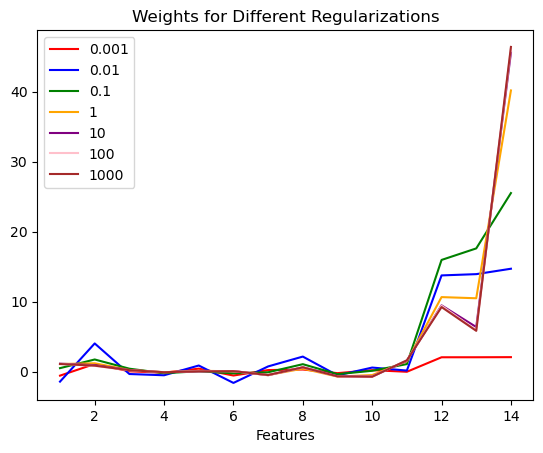

In [113]:
x=np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown']

# Plotting training and val errors
for i in range(7):
    plt.plot(x, weights[i][0], label=Clist[i], color=colors[i])


# Adding labels and title
plt.xlabel('Features')
#plt.ylabel('MSE Error')
plt.title('Weights for Different Regularizations')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

## SVR model with different parameters

epsilon:  0.01
Mean Squared Error for val set: 224.50792105557122
Mean Squared Error for train set: 248.6890408050623
epsilon:  0.1
Mean Squared Error for val set: 223.79242070597246
Mean Squared Error for train set: 247.37472124142695
epsilon:  1
Mean Squared Error for val set: 220.56307870877117
Mean Squared Error for train set: 240.90044869218778
epsilon:  5
Mean Squared Error for val set: 218.72690875192328
Mean Squared Error for train set: 228.77874536999187
epsilon:  10
Mean Squared Error for val set: 224.35240790434614
Mean Squared Error for train set: 226.22556939941953
epsilon:  15
Mean Squared Error for val set: 233.22491911855298
Mean Squared Error for train set: 229.00123350566403
epsilon:  20
Mean Squared Error for val set: 236.40596468547022
Mean Squared Error for train set: 231.32986154742204


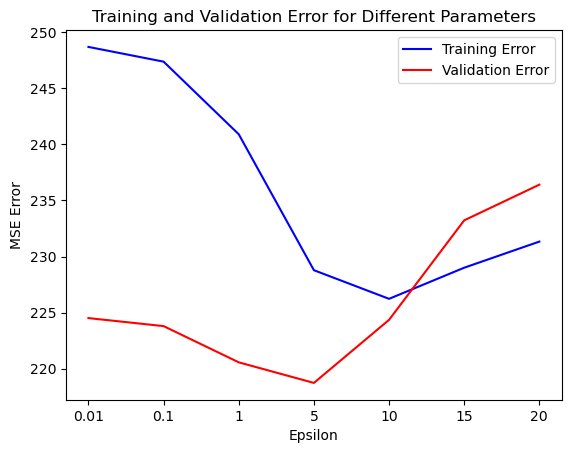

In [22]:
# Create a SVR model with different parameters (elipson for the margin relaxation)

eplist=[1e-2,0.1,1,5,10,15,20]
vallist=[]
trainlist=[]

for a in eplist:
    print("epsilon: ", a)
    model = SVR(kernel='linear',C=10,epsilon=a)

    # Train the model on the training data
    model.fit(X_train_scaled, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_val_scaled)

    # Calculate mean squared error 
    mse = mean_squared_error(y_val, y_pred)
    print("Mean Squared Error for val set:", mse)
    vallist.append(mse)

    # training error
    y_predt = model.predict(X_train_scaled)
    mse = mean_squared_error(y_train, y_predt)
    print("Mean Squared Error for train set:", mse)
    trainlist.append(mse)


x=[1,2,3,4,5,6,7]
labels=['0.01','0.1','1','5','10','15','20']
# Plotting training and val errors
plt.plot(x, trainlist, label='Training Error', color='blue')
plt.plot(x, vallist, label='Validation Error', color='red')
plt.xticks(x, labels)

# Adding labels and title
plt.xlabel('Epsilon')
plt.ylabel('MSE Error')
plt.title('Training and Validation Error for Different Parameters')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

## Optimal parameters and Test error

In [59]:
#from the results, use C=100, epsilon=5

model = SVR(kernel='linear',C=100,epsilon=5)

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test_scaled)

# Calculate mean squared error 
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error for test set:", mse)


Mean Squared Error for test set: 247.21868512915688


# Neural Networks

## Neural Networks with different regularizations

Alpha:  1e-05
Mean Squared Error for val set: 241.82854156394694
Mean Squared Error for train set: 200.7504787783677
Alpha:  0.001
Mean Squared Error for val set: 241.74074399023002
Mean Squared Error for train set: 201.01774140279701
Alpha:  0.01
Mean Squared Error for val set: 241.88653009110158
Mean Squared Error for train set: 200.8957385787846
Alpha:  0.1
Mean Squared Error for val set: 241.9964066811894
Mean Squared Error for train set: 200.8478170281677
Alpha:  1
Mean Squared Error for val set: 242.11339304399365
Mean Squared Error for train set: 201.24148115622756
Alpha:  10
Mean Squared Error for val set: 243.07223638215626
Mean Squared Error for train set: 205.34444084749578


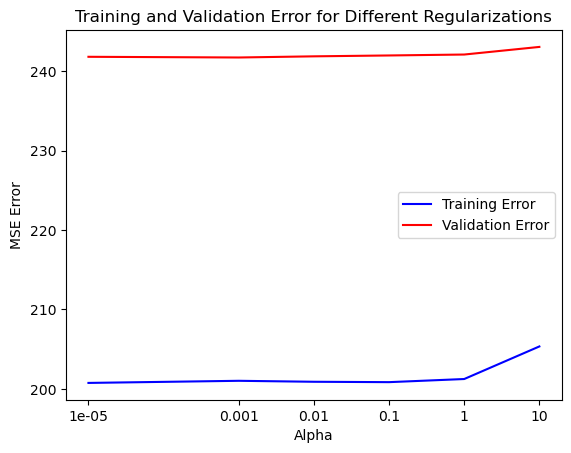

In [114]:
# Create an MLPRegressor model with regularization

alphalist=[1e-5,1e-3,1e-2,0.1,1,10]
vallist=[]
trainlist=[]
weights=[]

for a in alphalist:
    print('Alpha: ', a)
    model = MLPRegressor(hidden_layer_sizes=(15,5), activation='relu', solver='adam', random_state=42 ,max_iter=1000, alpha=a)

    # Train the model on the training data
    model.fit(X_train_scaled, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_val_scaled)
    w=model.coefs_
    wn=[np.linalg.norm(w[0]),np.linalg.norm(w[1])]
    weights.append(wn)

    # Calculate mean squared error 
    mse = mean_squared_error(y_val, y_pred)
    print("Mean Squared Error for val set:", mse)
    vallist.append(mse)
    
    # training error
    y_predt = model.predict(X_train_scaled)
    mse = mean_squared_error(y_train, y_predt)
    print("Mean Squared Error for train set:", mse)
    trainlist.append(mse)

x=[-5,-3,-2,-1,0,1]
# Plotting training and val errors
plt.plot(x, trainlist, label='Training Error', color='blue')
plt.plot(x, vallist, label='Validation Error', color='red')

# Adding labels and title
plt.xlabel('Alpha')
plt.xticks(x,[1e-5,1e-3,1e-2,0.1,1,10])
plt.ylabel('MSE Error')
plt.title('Training and Validation Error for Different Regularizations')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

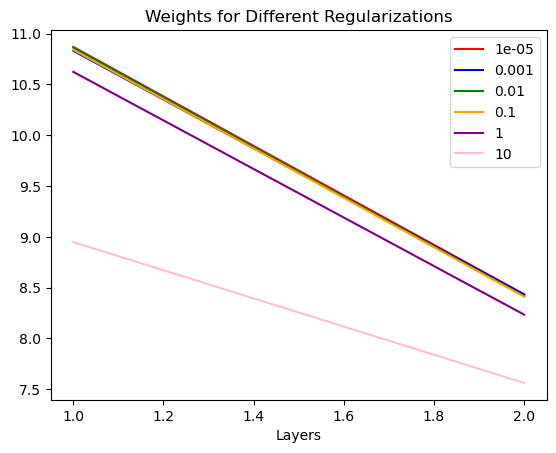

In [115]:
x=np.array([1,2])
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown']

# Plotting training and val errors
for i in range(6):
    plt.plot(x, weights[i], label=alphalist[i], color=colors[i])


# Adding labels and title
plt.xlabel('Layers')
#plt.ylabel('MSE Error')
plt.title('Weights for Different Regularizations')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

## Neural Networks with different activation function

activation:  relu
Mean Squared Error for val set: 241.9964066811894
Mean Squared Error for train set: 200.8478170281677
activation:  tanh


C:\Users\Ruilin Zhou\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Squared Error for val set: 5259.765626462805
Mean Squared Error for train set: 5037.867892955463
activation:  logistic
Mean Squared Error for val set: 5411.418682115236
Mean Squared Error for train set: 5183.806123419476


C:\Users\Ruilin Zhou\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


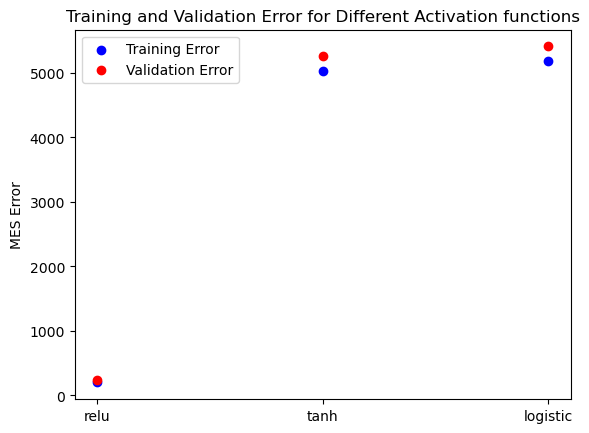

In [72]:
# Create an MLPRegressor model with different activation function

aflist=['relu','tanh','logistic']
vallist=[]
trainlist=[]

for a in aflist:
    print('activation: ', a )
    model = MLPRegressor(hidden_layer_sizes=(15,5), activation=a, solver='adam', random_state=42 ,max_iter=1000, alpha=0.1)

    # Train the model on the training data
    model.fit(X_train_scaled, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_val_scaled)

    # Calculate mean squared error 
    mse = mean_squared_error(y_val, y_pred)
    print("Mean Squared Error for val set:", mse)
    vallist.append(mse)
    
    # training error
    y_predt = model.predict(X_train_scaled)
    mse = mean_squared_error(y_train, y_predt)
    print("Mean Squared Error for train set:", mse)
    trainlist.append(mse)

x = [1,2,3]

# Define labels for x-axis
labels = ['relu','tanh','logistic']

# Plotting the scatter plot
plt.scatter(x, trainlist, label='Training Error', color='blue')
plt.scatter(x, vallist, label='Validation Error', color='red')

# Adding labels and title
plt.ylabel('MES Error')
plt.title('Training and Validation Error for Different Activation functions')

# Change x-axis to display labels
plt.xticks(x, labels)

# Adding legend
plt.legend()

# Displaying the scatter plot
plt.show()

## Neural Networks with different feature transformations (polynomial of different degrees)

degree:  1
Mean Squared Error for val set: 236.99911379778843
Mean Squared Error for train set: 214.40369694052072
degree:  2
Mean Squared Error for val set: 241.43698888508396
Mean Squared Error for train set: 176.42303868633684
degree:  3
Mean Squared Error for val set: 265.99426415035856
Mean Squared Error for train set: 150.0972653908985


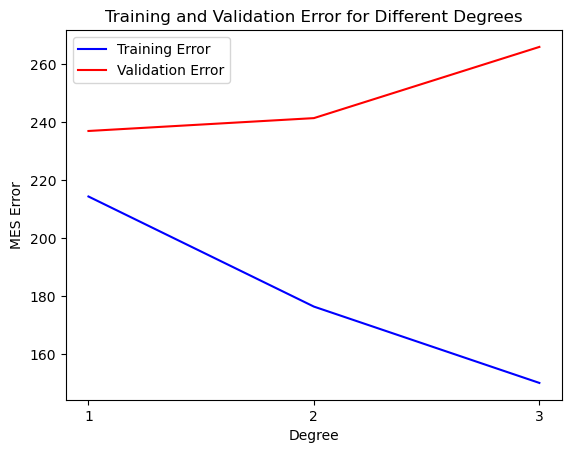

In [73]:
# Create an MLPRegressor model with different feature transformations (polynomial of different degree)


degree=[1,2,3]
vallist=[]
trainlist=[]

for d in degree:
    print('degree: ', d)
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_val_poly = poly.transform(X_val_scaled)
    model = MLPRegressor(hidden_layer_sizes=(15,5), activation='relu', solver='adam', random_state=42 ,max_iter=1000, alpha=0.1)

    # Train the model on the training data
    model.fit(X_train_poly, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_val_poly)

    # Calculate mean squared error 
    mse = mean_squared_error(y_val, y_pred)
    print("Mean Squared Error for val set:", mse)
    vallist.append(mse)
    
    # training error
    y_predt = model.predict(X_train_poly)
    mse = mean_squared_error(y_train, y_predt)
    print("Mean Squared Error for train set:", mse)
    trainlist.append(mse)

x = [1,2,3]

# Plotting the plot
plt.plot(x, trainlist, label='Training Error', color='blue')
plt.plot(x, vallist, label='Validation Error', color='red')

# Adding labels and title
plt.ylabel('MES Error')
plt.xlabel('Degree')
plt.xticks(x, ['1','2','3'])
plt.title('Training and Validation Error for Different Degrees')

# Adding legend
plt.legend()

# Displaying the scatter plot
plt.show()

## Optimal parameters and Test error

In [60]:
#from the results, use alpha=1,degree=1 transformation and relu
model = MLPRegressor(hidden_layer_sizes=(15,5), activation='relu', solver='adam', random_state=42 ,max_iter=1000, alpha=1)

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test_scaled)

# Calculate mean squared error 
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error for test set:", mse)

Mean Squared Error for test set: 250.08993477576968


# Different normalization (Minmax) and results

In [61]:
#use minmax normalization

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(X_train)

# Transform data using the fitted scaler
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [62]:
# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test_scaled)

# Calculate mean squared error 
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error for test set:", mse)

Mean Squared Error for test set: 248.28667488803606


In [63]:
model = SVR(kernel='linear',C=100,epsilon=5)

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test_scaled)

# Calculate mean squared error 
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error for test set:", mse)


Mean Squared Error for test set: 246.74765146622522


In [64]:

model = MLPRegressor(hidden_layer_sizes=(15,5), activation='relu', solver='adam', random_state=42 ,max_iter=1000, alpha=1)

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test_scaled)

# Calculate mean squared error 
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error for test set:", mse)

Mean Squared Error for test set: 271.0169003992352


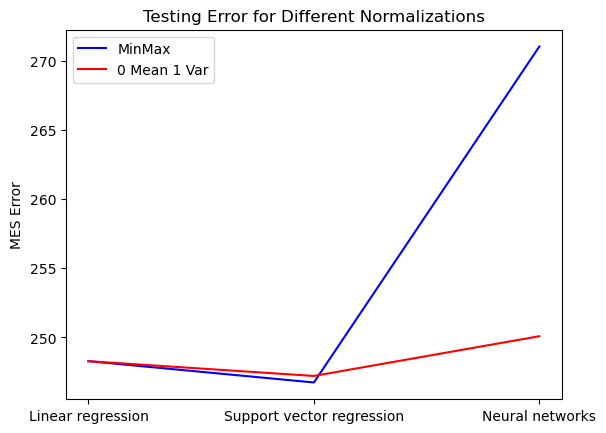

In [74]:
x=[1,2,3]

# Plotting the plot
plt.plot(x, [248.286,246.747,271.016], label='MinMax', color='blue')
plt.plot(x, [248.286,247.218,250.089], label='0 Mean 1 Var', color='red')

# Adding labels and title
plt.ylabel('MES Error')
#plt.xlabel('Model Name')
plt.xticks(x, ['Linear regression','Support vector regression','Neural networks'])
plt.title('Testing Error for Different Normalizations')

# Adding legend
plt.legend()

# Displaying the scatter plot
plt.show()